In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('household_power_consumption.txt', sep = ';',parse_dates = True,low_memory = False)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844765 entries, 0 to 1844764
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 126.7+ MB


In [5]:
data['date_time'] = data['Date'].str.cat(data['Time'], sep= ' ')
data.drop(['Date', 'Time'], inplace= True, axis = 1)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,16/12/2006 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,16/12/2006 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,16/12/2006 17:28:00


In [6]:
data.set_index(['date_time'], inplace=True)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
data.replace('?', nan, inplace=True)

In [8]:
data = data.astype('float')

In [9]:
np.isnan(data).sum()

Global_active_power      13513
Global_reactive_power    13513
Voltage                  13513
Global_intensity         13513
Sub_metering_1           13513
Sub_metering_2           13513
Sub_metering_3           13514
dtype: int64

In [10]:
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row, col]):
                data[row, col] = data[row-one_day, col]

In [11]:
fill_missing(data.values)

In [12]:
np.isnan(data).sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [13]:
data.to_csv('cleaned_data.csv')

In [14]:
dataset = pd.read_csv('cleaned_data.csv', parse_dates = True, index_col = 'date_time', low_memory = False)
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [15]:
#Downsampling the data into dáy-wise bins and sum the values of the timestamps falling into a bin.

data = dataset.resample('D').sum()

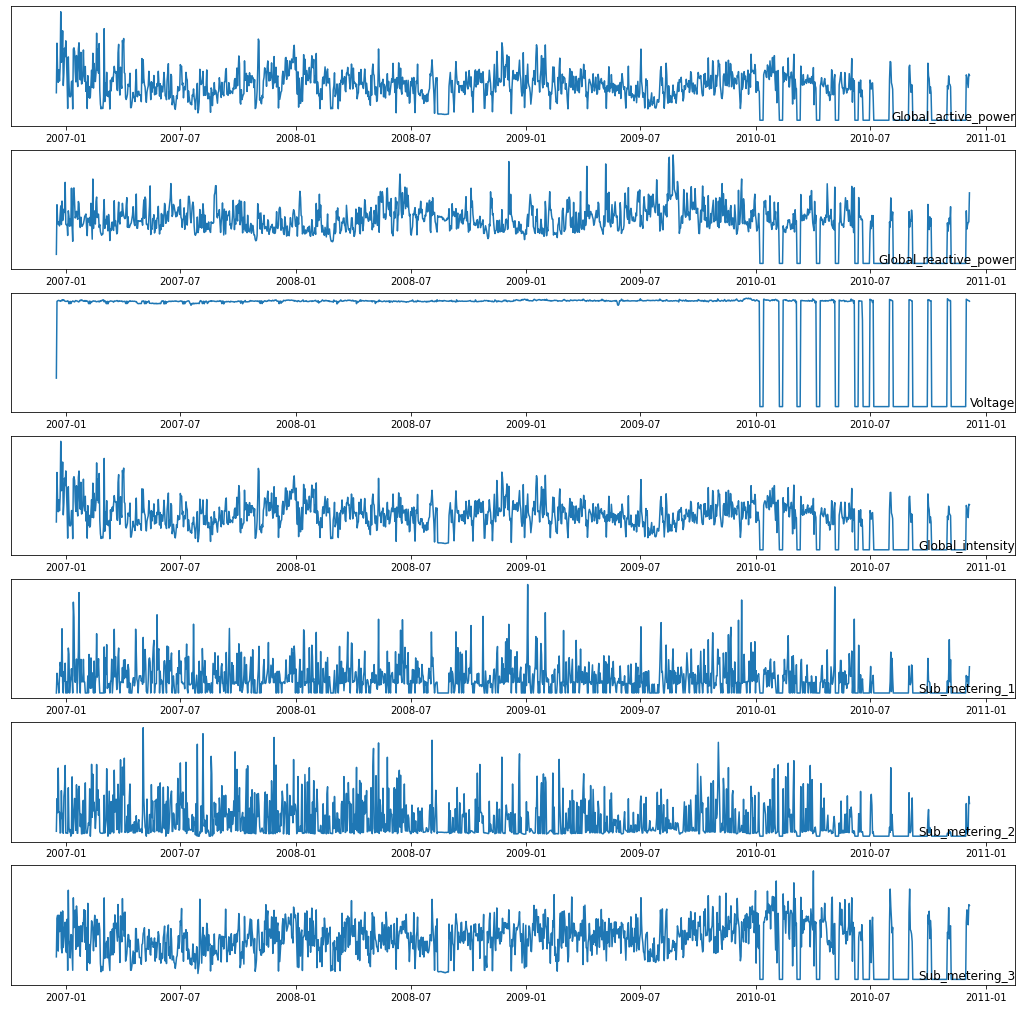

In [16]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    plt.plot(data[name])
    plt.title(name, y=0, loc = 'right')
    plt.yticks([])
plt.show()
fig.tight_layout()

In [17]:
years = ['2007', '2008', '2009', '2010']

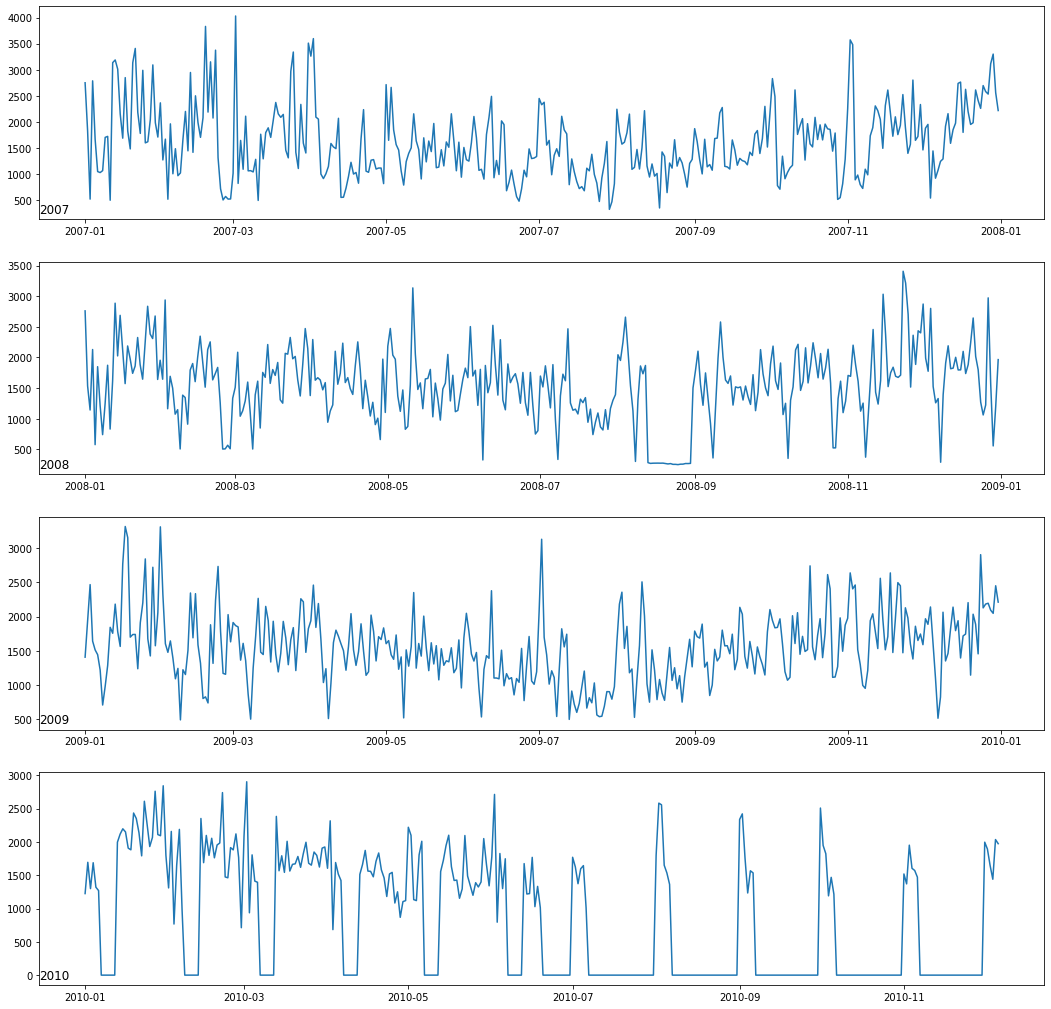

In [18]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    plt.plot(active_power_data['Global_active_power'])
    plt.title(str(year), y = 0, loc = 'left')
plt.show()
fig.tight_layout()

Year wise histogram plot of feature Global_active_power

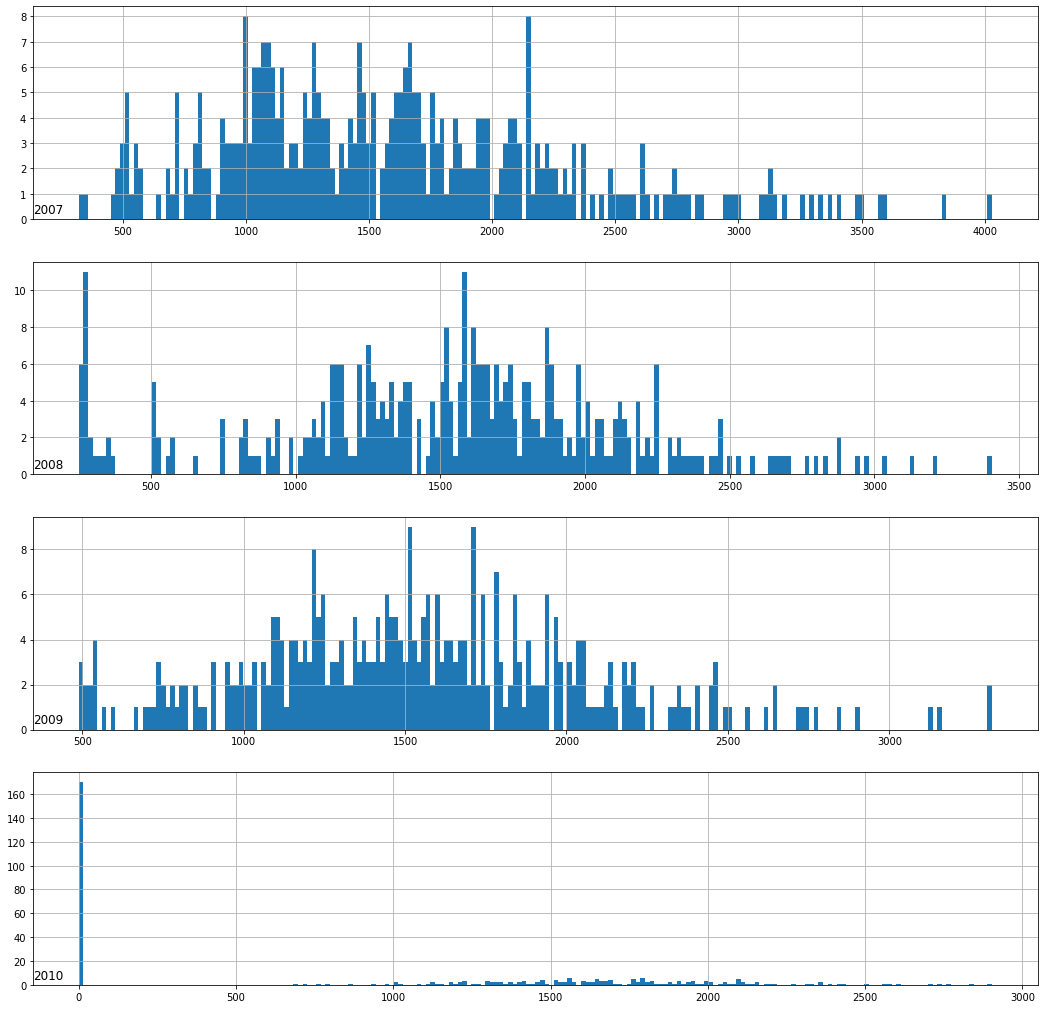

In [19]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    active_power_data['Global_active_power'].hist(bins = 200)
    plt.title(str(year), y = 0, loc = 'left')
plt.show()
fig.tight_layout()

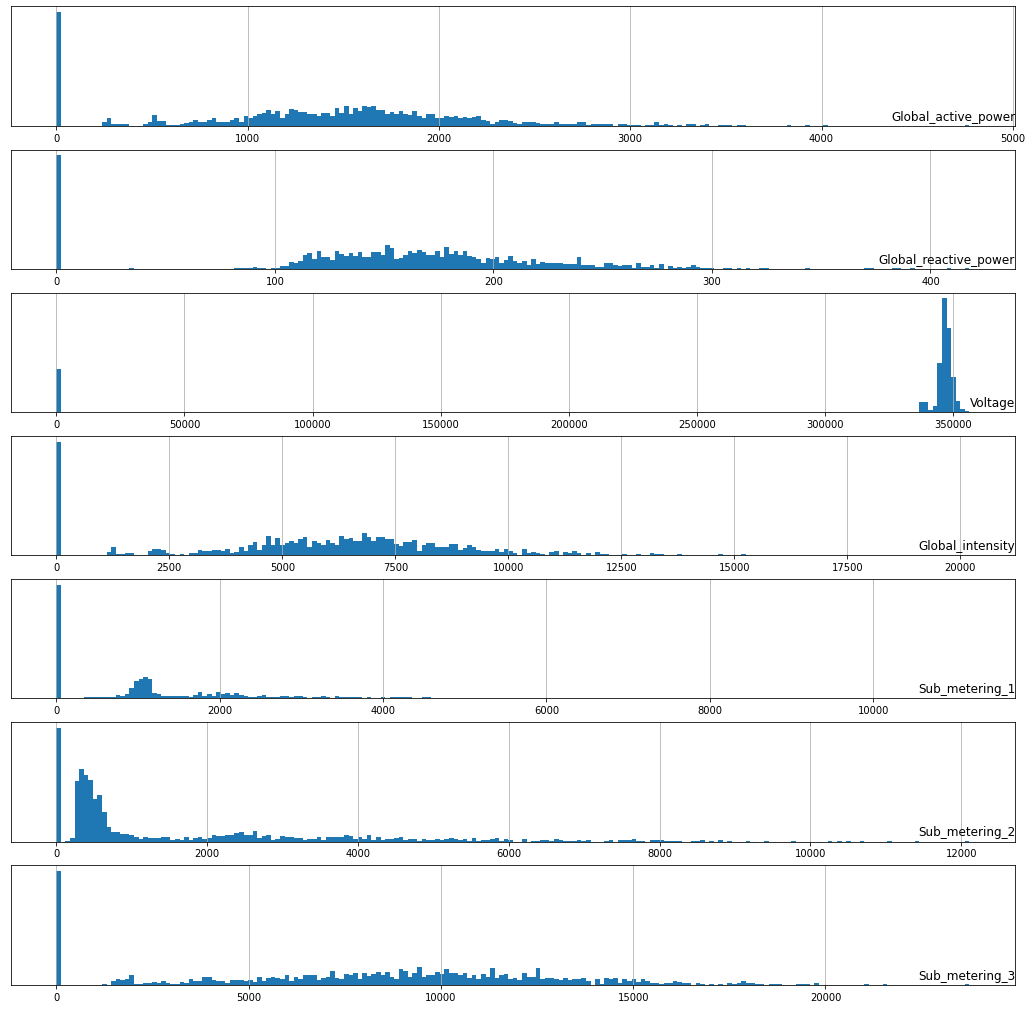

In [20]:
fig, ax = plt.subplots(figsize=(18,18))

for i in range(len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    data[name].hist(bins=200)
    plt.title(name, y=0, loc = 'right')
    plt.yticks([])
plt.show()
fig.tight_layout()

In [24]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [33]:
#here splitting the dataset upto end of 2009 is in train dataset and remaining we keeping it in test dataset.

data_train = data.loc[:'2009-12-31', :]['Global_active_power']
data_train.head()

date_time
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
Freq: D, Name: Global_active_power, dtype: float64

In [34]:
data_test = data['2010']['Global_active_power']
data_test.head()

date_time
2010-01-01    1224.252
2010-01-02    1693.778
2010-01-03    1298.728
2010-01-04    1687.440
2010-01-05    1320.158
Freq: D, Name: Global_active_power, dtype: float64

In [35]:
data_train.shape, data_test.shape

((1112,), (340,))

In [36]:
data_train = np.array(data_train)

In [37]:
#we are splitting the data weekly wise(7days)

X_train, y_train = [], []

for i in range(7, len(data_train)-7):
    X_train.append(data_train[i-7:i])
    y_train.append(data_train[i:i+7])

In [38]:
X_train, y_train = np.array(X_train), np.array(y_train) #converting list into numpy array

In [39]:
X_train.shape, y_train.shape

((1098, 7), (1098, 7))

In [40]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6
0,4773.386,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392
1,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108
2,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196
3,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004
4,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004,1824.760


In [41]:
#Normalising the dataset between 0 and 1

x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)

In [42]:
#Normalising the dataset

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)

In [43]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6
0,0.211996,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304
1,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000
2,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439
3,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439,0.551133
4,0.436748,0.325660,0.462304,1.000000,0.508439,0.551133,0.814446


In [46]:
X_train = X_train.reshape(1098, 7, 1) #Reshaping the shape into 3 dimensions to fit in the LSTM Model.
X_train.shape

(1098, 7, 1)

In [47]:
#building sequential model using Keras

reg = Sequential()
reg.add(LSTM(units = 200, activation = 'relu', input_shape=(7,1)))
reg.add(Dense(7))

In [48]:
reg.compile(loss='mse', optimizer='adam')

In [49]:
reg.fit(X_train, y_train, epochs = 100)

Epoch 1/100
35/35 [==============================] - 2s 16ms/step - loss: 0.0943
Epoch 2/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0252
Epoch 3/100
35/35 [==============================] - 1s 18ms/step - loss: 0.0229
Epoch 4/100
35/35 [==============================] - 1s 18ms/step - loss: 0.0243
Epoch 5/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0252
Epoch 6/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0234
Epoch 7/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0240
Epoch 8/100
35/35 [==============================] - 1s 17ms/step - loss: 0.0249
Epoch 9/100
35/35 [==============================] - 1s 18ms/step - loss: 0.0231
Epoch 10/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0242
Epoch 11/100
35/35 [==============================] - 1s 17ms/step - loss: 0.0228
Epoch 12/100
35/35 [==============================] - 1s 18ms/step - loss: 0.0235
Epoch 13/100
35/35 [=====

In [50]:
data_test = np.array(data_test)

In [51]:
#here we are splitting the data weekly wise(7days)

X_test, y_test = [], []

for i in range(7, len(data_test)-7):
    X_test.append(data_test[i-7:i])
    y_test.append(data_test[i:i+7])

In [52]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [55]:
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)
X_test.shape

(326, 7)

In [57]:
X_test = X_test.reshape(326,7,1)
X_test.shape

(326, 7, 1)

In [58]:
y_pred = reg.predict(X_test)

In [59]:
#bringing y_pred values to their original forms by using inverse transform

y_pred = y_scaler.inverse_transform(y_pred)

In [60]:
y_true = y_scaler.inverse_transform(y_test)

Evaluating the model
Here, we using metric as mean square error since it is a regression problem.

In [68]:
def evaluate_model(y_true, y_predicted):
    scores = []
    
    #calculate scores for each day
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    
    #calculate score for whole prediction
    total_score = 0
    for row in range(y_true.shape[0]):
        for col in range(y_predicted.shape[1]):
            total_score = total_score + (y_true[row, col] - y_predicted[row, col])**2
    total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))
    
    return total_score, scores

In [62]:
evaluate_model(y_true, y_pred)

(223.66414385063564,
 [23.755551511896517,
  19.149462663780774,
  196.17614003285703,
  410.0865160205628,
  209.69801685827352,
  121.53376189597935,
  289.56652857013654])

In [63]:
#standard deviation

np.std(y_true[0])

0.2449465129684969

Since the model result 23.75 is less than the standard deviation obtained we can say that our model is giving a good performance on the test dataset.